In [1]:
import pandas as pd
import sklearn
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn
import matplotlib as plt
from nltk.stem.porter import *
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer 
import nltk
import string
import numpy as np


wl = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words("english")


In [2]:
data = pd.read_csv("labeled_data.csv")
pd.set_option("display.max_colwidth",100)

In [3]:
data.head(8)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for some..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit g..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;


In [4]:
data.tail(7)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
24776,25289,3,3,0,0,0,you're all niggers
24777,25290,3,2,1,0,0,you're such a retard i hope you get type 2 diabetes and die from a sugar rush you fucking faggot...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies
24782,25296,3,0,0,3,2,"~~Ruffled | Ntac Eileen Dahlia - Beautiful color combination of pink, orange, yellow &amp; white..."


In [5]:
#Making labels for the model
data['labels'] = data['class'].map({
    2:0,
    0:1,
    1:1,    
})

In [6]:
data.labels.value_counts()

1    20620
0     4163
Name: labels, dtype: int64

In [7]:
#Dropping irrelevant stuff
data = data.drop(pd.DataFrame(data).columns[[0,1,2,3,4,5]],axis=1)

In [8]:
print(f"Total number of missing Tweets: {data['tweet'].isnull().sum()}")
print(f"Total number of missing Labels: {data['labels'].isnull().sum()}",'\n')

#If null values, we can use the following command
#data = data.dropna()


print(f"Total number of Non Offensive: {len(data[data['labels']== 0])}")
print(f"Total number of Offensive: {len(data[data['labels']== 1])}")

data.head()

Total number of missing Tweets: 0
Total number of missing Labels: 0 

Total number of Non Offensive: 4163
Total number of Offensive: 20620


,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,1


<Axes: >

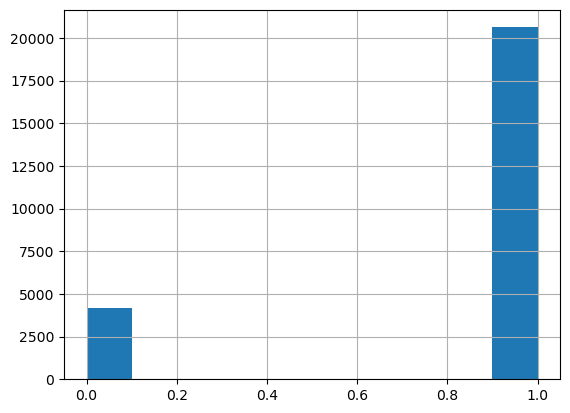

In [9]:
data['labels'].hist()

In [10]:
data.describe()

,labels
count,24783.000000
mean,0.832022
std,0.373854
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
#Making preprocessor to clean data

special_symbols = ["#ff", "ff", "rt"]
stopwords.extend(special_symbols)

def preprocess(text):
    """
    Accepts a text string and replaces:
    1) urls with ""
    2) lots of whitespace with one instance
    3) mentions with ""
    4) removes punctuation
    5) split text with anything other than word
    6) removes stopwords
    7) lemmatize
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+' 
    
    dat = re.sub(space_pattern, ' ', text)
    dat2 = re.sub(giant_url_regex, '', dat)
    dat3 = re.sub(mention_regex, '', dat2)
    dat4 = "".join([d for d in dat3 if d not in string.punctuation])
    dat5 = re.split('\W+',dat4)
    dat6 = [d for d in dat5 if d not in stopwords] #stopwords removal
    dat7 = [stemmer.stem(d) for d in dat6] #enable/disable stemming
    text = " ".join(dat7)
    return text


def tokenize(tweet):
    """Tokenize but without the stemming"""
    tweet = " ".join(re.split("\W+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=None, #tokenize
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=None, #stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

#c_vectorizer = CountVectorizer(
#    tokenizer=None,
#    preprocessor=preprocess,
#    ngram_range=(1, 1),
#    stop_words=None,#stopwords
#    decode_error='replace',
#    max_features=10000,
#    )

In [12]:
#Random Forest

In [13]:
rdf = Pipeline([
    ('vectorizer_tfidf',vectorizer),
    ('Random Forest Classifier',RandomForestClassifier())
])

#c_rdf = Pipeline([
#    ('Count_vectorizer',c_vectorizer),
#    ('Random Forest Classifier',RandomForestClassifier())
#])

x_train,x_test,y_train,y_test = train_test_split(data['tweet'],data['labels'],test_size=0.34,random_state=2002)

rdf.fit(x_train,y_train)
#c_rdf.fit(x_train,y_train)

y_pred = rdf.predict(x_test)
#c_y_pred = c_rdf.predict(x_test)

print(classification_report(y_test,y_pred))
#print(classification_report(y_test,c_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1462
           1       0.97      0.97      0.97      6965

    accuracy                           0.95      8427
   macro avg       0.90      0.91      0.91      8427
weighted avg       0.95      0.95      0.95      8427



Random Forest Accuracy: 0.9466002135991456


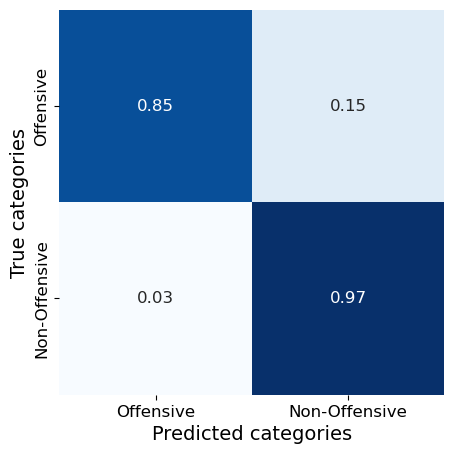

In [33]:
print("Random Forest Accuracy:",accuracy_score(y_test, y_pred))

confusion_mat = confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_mat[i,:]/float(confusion_mat[i,:].sum())
names=['Offensive','Non-Offensive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

plt.pyplot.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Blues',cbar=False, square=True,fmt='.2f')
plt.pyplot.ylabel(r'True categories',fontsize=14)
plt.pyplot.xlabel('Predicted categories',fontsize=14)
plt.pyplot.tick_params(labelsize=12)

In [15]:
#Support Vector Machine

In [16]:
SVM = Pipeline([
    ('vectorizer_tfidf',vectorizer),
    ('SVM',svm.SVC())
])

x_train,x_test,y_train,y_test = train_test_split(data['tweet'],data['labels'],test_size=0.34,random_state=2002)
SVM.fit(x_train,y_train)

y_pred_2 = SVM.predict(x_test)

print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1462
           1       0.95      0.98      0.96      6965

    accuracy                           0.94      8427
   macro avg       0.91      0.87      0.89      8427
weighted avg       0.94      0.94      0.94      8427



Suppor Vector Machine Accuracy: 0.9382935801590127


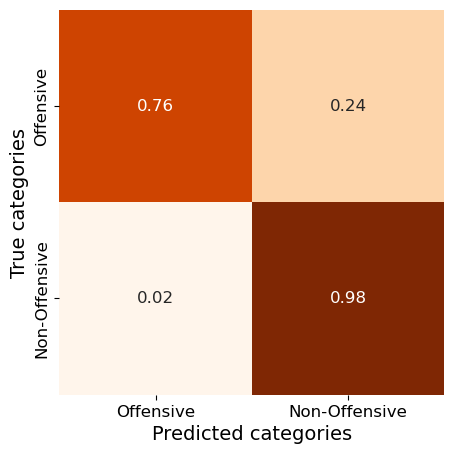

In [34]:
print("Suppor Vector Machine Accuracy:",accuracy_score(y_test, y_pred_2))

confusion_mat_svc = confusion_matrix(y_test,y_pred_2)
matrix_proportions_svc = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions_svc[i,:] = confusion_mat_svc[i,:]/float(confusion_mat_svc[i,:].sum())
names=['Offensive','Non-Offensive']
confusion_df = pd.DataFrame(matrix_proportions_svc, index=names,columns=names)

plt.pyplot.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Oranges',cbar=False, square=True,fmt='.2f')
plt.pyplot.ylabel(r'True categories',fontsize=14)
plt.pyplot.xlabel(r'Predicted categories',fontsize=14)
plt.pyplot.tick_params(labelsize=12)


In [18]:
#MultimomialNB

In [19]:
mnb = Pipeline([
    ('vectorizer_tfidf',vectorizer),
    ('MNB',MultinomialNB())
])

x_train,x_test,y_train,y_test = train_test_split(data['tweet'],data['labels'],test_size=0.34,random_state=2002)
mnb.fit(x_train,y_train)

y_pred_3 = mnb.predict(x_test)

print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1462
           1       0.96      0.92      0.94      6965

    accuracy                           0.91      8427
   macro avg       0.83      0.87      0.85      8427
weighted avg       0.91      0.91      0.91      8427



MultinomialNB Accuracy: 0.9055417111664886


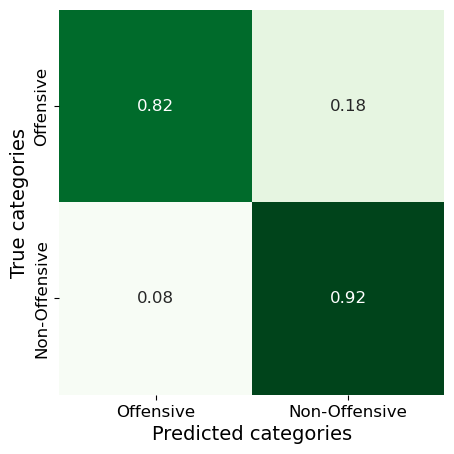

In [35]:
print("MultinomialNB Accuracy:",accuracy_score(y_test, y_pred_3))

confusion_mat_mnb = confusion_matrix(y_test,y_pred_3)
matrix_proportions_mnb = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions_mnb[i,:] = confusion_mat_mnb[i,:]/float(confusion_mat_mnb[i,:].sum())
names=['Offensive','Non-Offensive']
confusion_df = pd.DataFrame(matrix_proportions_mnb, index=names,columns=names)

plt.pyplot.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='Greens',cbar=False, square=True,fmt='.2f')
plt.pyplot.ylabel(r'True categories',fontsize=14)
plt.pyplot.xlabel(r'Predicted categories',fontsize=14)
plt.pyplot.tick_params(labelsize=12)

In [21]:
a = preprocess("you are soo cute")

print(a)

if rdf.predict([a]) == [1]:
    rdf_prediction = "Offensive"
else:
    rdf_prediction = "Non-Offensive"
    
if mnb.predict([a]) == [1]:
    mnb_prediction = "Offensive"
else:
    mnb_prediction = "Non-Offensive"
    
if SVM.predict([a]) == [1]:
    SVM_prediction = "Offensive"
else:
    SVM_prediction = "Non-Offensive"
    
print(f"Random Forest Model: {rdf_prediction}")
print(f"Support Vector Machine Model: {SVM_prediction}")
print(f"MultinomialNB Model: {mnb_prediction}")


soo cute
Random Forest Model: Non-Offensive
Support Vector Machine Model: Non-Offensive
MultinomialNB Model: Offensive


In [22]:
print(list(y_test[10:40]))
print(list(y_pred_3[10:40]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


In [23]:
data.tail(10)

,tweet,labels
24773,you niggers cheat on ya gf's? smh....,1
24774,you really care bout dis bitch. my dick all in yo feelings,1
24775,"you worried bout other bitches, you need me for?",1
24776,you're all niggers,1
24777,you're such a retard i hope you get type 2 diabetes and die from a sugar rush you fucking faggot...,1
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8...,1
24779,"you've gone and broke the wrong heart baby, and drove me redneck crazy",0
24780,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,1
24781,youu got wild bitches tellin you lies,1
24782,"~~Ruffled | Ntac Eileen Dahlia - Beautiful color combination of pink, orange, yellow &amp; white...",0


In [40]:
r = matrix_proportions
s = matrix_proportions_svc
m = matrix_proportions_mnb

a = ["Random Forest","Support Vector","MultinomialNB"]
i = ['Accuracy','True Positive','True Negative','False Positive', 'False Negative']
ac = {
    "Random Forest":[accuracy_score(y_test, y_pred),r[0,0],r[0,1],r[1,0],r[1,1]],
    "Support Vector":[accuracy_score(y_test, y_pred_2),s[0,0],s[0,1],s[1,0],s[1,1]],
    "MultinomialNB":[accuracy_score(y_test, y_pred_3),m[0,0],m[0,1],m[1,0],m[1,1]]
}
pd.DataFrame(ac,index=i,columns=a)

,Random Forest,Support Vector,MultinomialNB
Accuracy,0.946600,0.938294,0.905542
True Positive,0.854993,0.761286,0.823529
True Negative,0.145007,0.238714,0.176471
False Positive,0.034171,0.024551,0.077243
False Negative,0.965829,0.975449,0.922757
